In [117]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from modules import cleanmodule as cm


df = pd.read_csv("/Users/isar/PycharmProjects/films-data-science/datasets/films-imdb/IMDb movies.csv", low_memory=False)
df = df[df['metascore'].notna()] # keep rows where metascore not NaN
df['isgood'] = np.where(df['metascore'] > 56, 1, 0)
df.head()
#df['isgood'].value_counts()
df.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
isgood                     int64
dtype: object

In [109]:
print(len(df.index)) # nb rows
df['country'] = df['country'].apply(cm.clean_countries).astype('str')
df['date_published'] = df['date_published'].apply(clean_dates).astype('datetime64')
df = df[df['year'].notna()]
df = df[df['country'].notna()]
df = df[df['budget'].notna()]
df['budget'] = df.apply(clean_currency, axis=1, args=["budget"]).astype('float')
df['worlwide_gross_income'] = df.apply(clean_currency, axis=1, args=["worlwide_gross_income"]).astype('float')
#df.dtypes
#df.loc[df['title'] == "Jeanne"]
df.head()


13305


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,isgood
76,tt0006864,Intolerance,Intolerance: Love's Struggle Throughout the Ages,1916,1918-02-24,"Drama, History",163,USA,English,D.W. Griffith,...,"The story of a poor young woman, separated by ...",7.8,13875,3377076.62,NaN,NaN,99.0,111.0,77.0,1
506,tt0017136,Metropolis,Metropolis,1927,1928-10-01,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,...,In a futuristic city sharply divided between t...,8.3,156076,33691028.30,$ 1236166,11811336.55,98.0,495.0,208.0,1
566,tt0018037,Il cantante di jazz,The Jazz Singer,1927,1928-02-04,"Drama, Music, Musical",88,USA,English,Alan Crosland,...,The son of a Jewish Cantor must defy the tradi...,6.5,8866,3692926.88,NaN,NaN,66.0,104.0,63.0,1
628,tt0018773,Il circo,The Circus,1928,1928-10-01,"Comedy, Romance",72,USA,English,Charles Chaplin,...,The Tramp finds work and the girl of his dream...,8.1,27414,7875910.40,NaN,235542.23,90.0,327.0,65.0,1
714,tt0019777,The Cocoanuts,The Cocoanuts,1929,1929-08-03,"Comedy, Musical",96,USA,English,"Robert Florey, Joseph Santley",...,"During the Florida land boom,",7.0,6900,4375505.78,NaN,NaN,69.0,71.0,43.0,1


In [73]:
tokeep =  ['genre', 'language', 'director', 'duration']

# on trie si il reste de NaN
for tk in tokeep:
    df = df[df[tk].notna()]
    
target = df["isgood"]
inputs = df.loc[:, tokeep]
inputs

,genre,language,director,duration
76,"Drama, History",English,D.W. Griffith,163
506,"Drama, Sci-Fi",German,Fritz Lang,153
566,"Drama, Music, Musical",English,Alan Crosland,88
628,"Comedy, Romance",English,Charles Chaplin,72
714,"Comedy, Musical",English,"Robert Florey, Joseph Santley",96
...,...,...,...,...
85460,"Animation, Drama, Family",Japanese,Makoto Shinkai,112
85503,Drama,"English, Italian, Russian",Abel Ferrara,115
85592,"Drama, History",English,Matthew E. Rosen,127
85618,Drama,English,Dan Sallitt,94


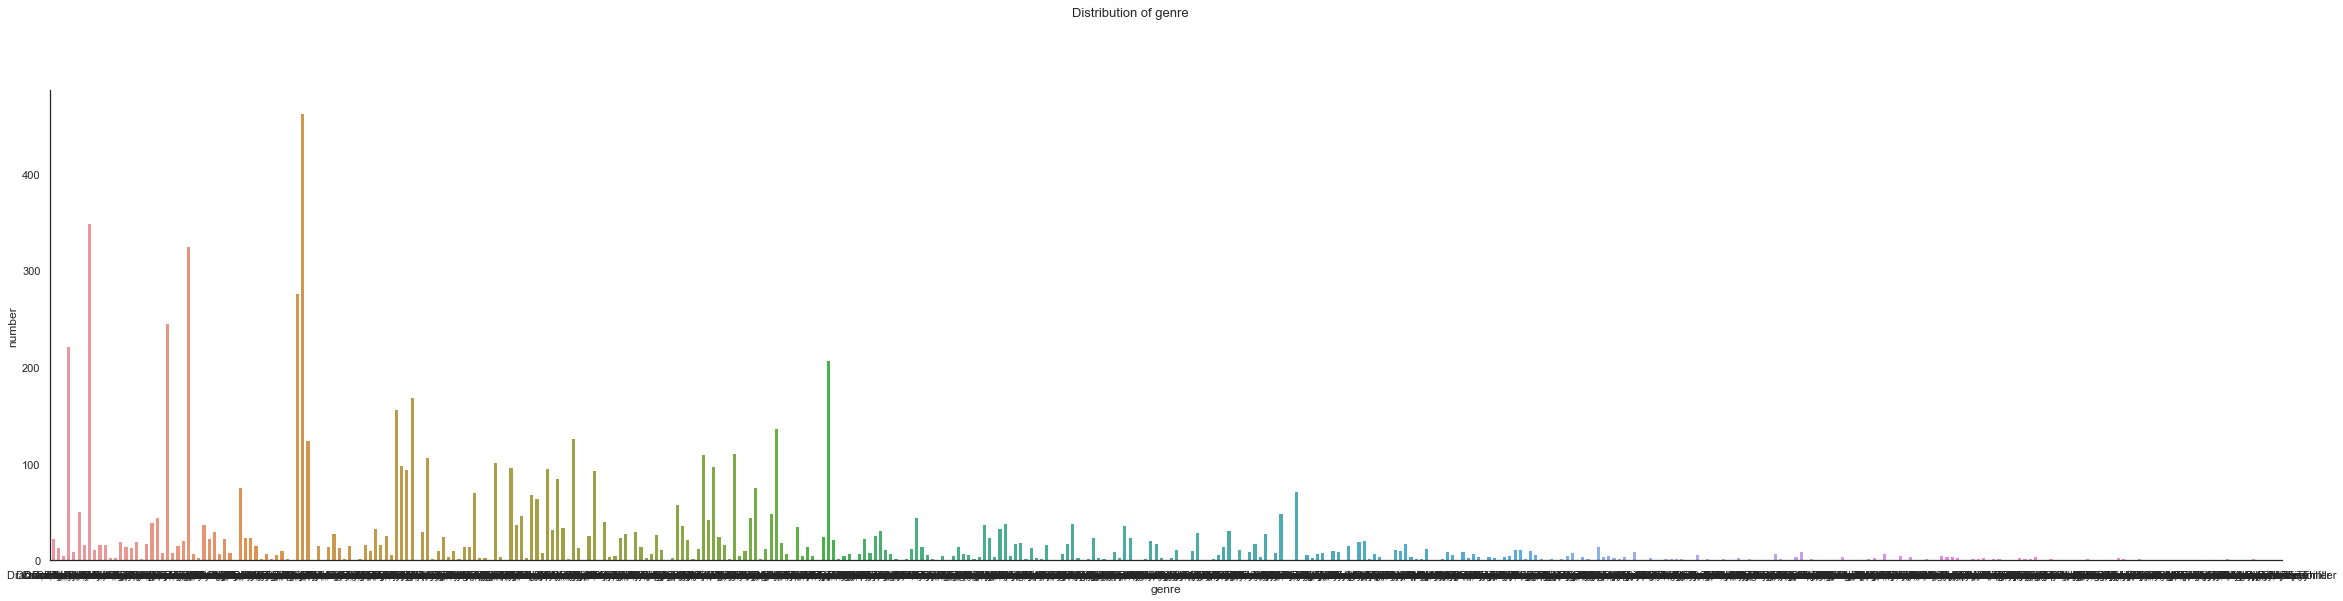

In [89]:
# for integrated graphs:
%matplotlib notebook

from modules import visumodule # pip install seaborn
import importlib
importlib.reload(visumodule)

vm = visumodule.Visualiser(df)

vm.distribution("genre")

In [75]:
from sklearn.preprocessing import LabelEncoder

In [76]:
inputs_dict = {}
for tk in tokeep:
    inputs_dict[tk] = LabelEncoder()

In [77]:
# transforme champ (str) en champ_n (int)
for tk in tokeep:
    inputs[tk+"_n"] = inputs_dict[tk].fit_transform(inputs[tk])
inputs.head()

,genre,language,director,duration,genre_n,language_n,director_n,duration_n
76,"Drama, History",English,D.W. Griffith,163,325,69,680,101
506,"Drama, Sci-Fi",German,Fritz Lang,153,362,880,1101,91
566,"Drama, Music, Musical",English,Alan Crosland,88,343,69,56,26
628,"Comedy, Romance",English,Charles Chaplin,72,257,69,510,10
714,"Comedy, Musical",English,"Robert Florey, Joseph Santley",96,251,69,2860,34


In [78]:
inputs_n = inputs.drop(tokeep,axis="columns")
inputs_n.head()

,genre_n,language_n,director_n,duration_n
76,325,69,680,101
506,362,880,1101,91
566,343,69,56,26
628,257,69,510,10
714,251,69,2860,34


In [79]:
from sklearn import tree # AVANT DE FAIRE UN ARBRE FAISONS DES CORRELATIONS VISUELLES

In [80]:
model = tree.DecisionTreeClassifier()

In [81]:
model.fit(inputs_n,target)

DecisionTreeClassifier()

In [82]:
#model.predict([[1462,125,294]])

In [83]:
nb_true = 0
nb_false = 0
for i in range(0, len(target)):
    inp = inputs_n.iloc[i]
    if target.iloc[i] == model.predict([inp]):
        nb_true+=1
    else:
        nb_false+=1
print(nb_true/(nb_true+nb_false))

# en fait on peut juste faire ça
model.score(inputs_n,target)

0.9992214869599065


0.9992214869599065

In [84]:
from sklearn.model_selection import train_test_split
input_train, input_test, target_train, target_test = train_test_split(inputs_n, target)

In [85]:
model_train = tree.DecisionTreeClassifier()
model_train.fit(input_train,target_train)


DecisionTreeClassifier()

In [91]:
model_train.score(input_train, target_train)

0.9993079584775086

In [90]:
model_train.score(input_test, target_test)

0.5900363258951739

In [88]:
# belle prez si viz pour mise en contexte
# todo find most important features (ex: https://towardsdatascience.com/predicting-imdb-movie-ratings-using-supervised-machine-learning-f3b126ab2ddb)
# todo predict financial success using regr in new notebook
# modulise data cleaner